# Машинное обучение

## Подготовка библиотек

In [57]:
import pandas as pd
import numpy as np

import shap
import sklearn
import catboost

import seaborn as sns
import matplotlib.pyplot as plt;

from sklearn.model_selection import train_test_split

from catboost import CatBoostClassifier, MetricVisualizer
from sklearn.metrics import roc_auc_score, accuracy_score

from sklearn import metrics

from sklearn.metrics import f1_score
from sklearn.metrics import precision_recall_curve, PrecisionRecallDisplay

In [2]:
sns.set_style("darkgrid") # серая подложка графиков

## Загрузка данных

In [4]:
train = pd.read_csv("/kaggle/input/day-02/dataset_01_06.csv")
train = train.set_index("client_id") # устанавливаем индекс клиента
train = train.drop_duplicates() # убираем дубликаты

In [6]:
train.shape

(32092, 3647)

In [7]:
train.head(5)

invalid value encountered in greater
invalid value encountered in less
invalid value encountered in greater
invalid value encountered in greater
invalid value encountered in less
invalid value encountered in greater


,prepay_ind_p1m,latitude_1m,building_type_key_1m,deferred_pay_1m,pay_count_p3m,crm_init_count_d1m,crm_out_count_p3m,prepay_ind_d2m,basic_day_debt_bad_max_d1m,bad_debt_p1m,...,avg_view_genre_dosug_2m,is_multiscreen_p1m,avg_view_other_p1m,count_purchase_1m,avg_view_multi_1m,total_duration_1m,avg_view_adult_1m,avg_view_category_18_d3m,avg_view_tvmarket_p2m,avg_view_category_0_2m
client_id,,,,,,,,,,,,,,,,,,,,,
161291,0.0,51.363170,377945938.0,1.0,6.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.00,0.0,18.37,1470.87,0.0,0.0,0.00,0.0
87256,0.0,50.547399,377945938.0,NaN,3.0,0.0,0.0,0.0,0.0,0.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,NaN,NaN
128419,0.0,51.738616,377945938.0,1.0,8.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,77.63,10.0,88.69,15110.70,0.0,0.0,0.00,0.0
198395,0.0,50.087963,377945938.0,NaN,3.0,0.0,0.0,0.0,0.0,0.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,NaN,NaN
194340,0.0,51.700059,377945938.0,NaN,3.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.00,0.0,173.79,7342.57,0.0,0.0,4.67,0.0


## Утечки данных

Ошибочное использование информации, которая будет недоступна при практическом применении модели

-> Искусственно завышенная оценка качества модели на этапе обучения и валидации

-> Ухудшение точности модели при работе с реальными данными

Переобученность

In [16]:
leak_columns = []
leak_columns.extend([col for col in train.columns if col.startswith('charg_inst')])
leak_columns.extend([col for col in train.columns if col.startswith('charg_sale')])
leak_columns.extend([col for col in train.columns if col.startswith('hgid')])
leak_columns.extend([col for col in train.columns if col.startswith('hflat')])
leak_columns.extend([col for col in train.columns if col.startswith('hlid')])
leak_columns.extend([col for col in train.columns if col.startswith('latitude_1m')])
leak_columns.extend([col for col in train.columns if col.startswith('longitude_1m')])
print(leak_columns) # могут быть утечками в данных

['charg_inst_iptv_p3m', 'charg_inst_iptv_d2m', 'charg_inst_shpd_3m', 'charg_inst_ota_1m', 'charg_inst_ota_3m', 'charg_inst_iptv_3m', 'charg_inst_ota_p3m', 'charg_inst_shpd_1m', 'charg_inst_iptv_1m', 'charg_inst_shpd_d3m', 'charg_inst_shpd_2m', 'charg_inst_shpd_d2m', 'charg_inst_iptv_d3m', 'charg_inst_ota_d1m', 'charg_inst_shpd_d1m', 'charg_inst_iptv_2m', 'charg_inst_shpd_p3m', 'charg_inst_ota_p1m', 'charg_inst_iptv_p1m', 'charg_inst_shpd_p1m', 'charg_inst_iptv_p2m', 'charg_inst_shpd_p2m', 'charg_inst_ota_p2m', 'charg_inst_ota_d2m', 'charg_inst_iptv_d1m', 'charg_inst_ota_d3m', 'charg_inst_ota_2m', 'charg_sale_shpd_d2m', 'charg_sale_other_3m', 'charg_sale_other_p1m', 'charg_sale_shpd_p1m', 'charg_sale_other_1m', 'charg_sale_iptv_d3m', 'charg_sale_other_d2m', 'charg_sale_iptv_d1m', 'charg_sale_other_p2m', 'charg_sale_shpd_p3m', 'charg_sale_shpd_3m', 'charg_sale_other_p3m', 'charg_sale_iptv_1m', 'charg_sale_shpd_d1m', 'charg_sale_iptv_2m', 'charg_sale_other_2m', 'charg_sale_shpd_1m', 'char

## Удаление признаков утечки

In [17]:
train.drop(columns=leak_columns, inplace=True)

In [18]:
train.shape

(32092, 3587)

## Разделение на признаки и предсказываемую величину

* Признаки (features) — это переменные или характеристики, которые используются для прогнозирования
* Предсказываемая величина (target) — это величина, которую мы пытаемся предсказать с помощью модели машинного обучения
    * В задачах регрессии это может быть непрерывная величина
    * В задачах классификации это может быть категория или метка

In [21]:
# признаки
X_features = train.copy()
X_features.drop(columns=['label'], inplace=True) # удаляем признак предсказываемой величины
print('train: ', train.shape)
print('X_features: ', X_features.shape) # DataFrame

train:  (32092, 3587)
X_features:  (32092, 3586)


In [22]:
# предсказываемая величина
Y_target = train['label'].copy()
print('Y_target: ', Y_target.shape) # Series

Y_target:  (32092,)


## Разделение признаков на категориальные и численные

* `'object'` - категориальные
* `'number'` - численные

In [24]:
# категориальные
X_cat = X_features.select_dtypes(include='object')
X_cat.shape

(32092, 8)

In [25]:
# численные
X_num = X_features.select_dtypes(include='number')
X_num.shape

(32092, 3578)

## Заполнение пропусков

In [26]:
X_num.isna() # поиск пропусков - NaN (по всей таблице)

,prepay_ind_p1m,building_type_key_1m,deferred_pay_1m,pay_count_p3m,crm_init_count_d1m,crm_out_count_p3m,prepay_ind_d2m,basic_day_debt_bad_max_d1m,bad_debt_p1m,correction_pay_ind_d2m,...,avg_view_genre_dosug_2m,is_multiscreen_p1m,avg_view_other_p1m,count_purchase_1m,avg_view_multi_1m,total_duration_1m,avg_view_adult_1m,avg_view_category_18_d3m,avg_view_tvmarket_p2m,avg_view_category_0_2m
client_id,,,,,,,,,,,,,,,,,,,,,
161291,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
87256,False,False,True,False,False,False,False,False,False,False,...,True,True,True,True,True,True,True,False,True,True
128419,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
198395,False,False,True,False,False,False,False,False,False,False,...,True,True,True,True,True,True,True,False,True,True
194340,False,False,True,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
198787,False,False,True,False,False,False,False,False,False,False,...,True,True,True,True,True,True,True,False,True,True
176215,False,True,True,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
130630,False,False,True,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False


In [27]:
X_num.isna().sum() # поиск пропусков - NaN (сумма по столбцам)

prepay_ind_p1m                  0
building_type_key_1m          892
deferred_pay_1m             29120
pay_count_p3m                   0
crm_init_count_d1m              0
                            ...  
total_duration_1m           19491
avg_view_adult_1m           19491
avg_view_category_18_d3m        0
avg_view_tvmarket_p2m       19639
avg_view_category_0_2m      19470
Length: 3578, dtype: int64

In [28]:
X_num.isna().sum().sum() # поиск пропусков - NaN (сумма по всей таблице)

41147653

In [29]:
X_num = X_num.fillna(0) # заполнение пропусков нулями

In [30]:
X_num.isna().sum().sum() # нет пропусков - 0

0

## Преобразование категориальных признаков в числовой формат (One-Hot Encoding)

* Многие алгоритмы машинного обучения требуют, чтобы все данные были числовыми
* Избегаем создания неявных порядковых отношений между категориями. Кодирование категорий числами (например, 1, 2, 3) может ввести модель в заблуждение, будто некоторые категории имеют порядок или значимость
* Избегаем неправильных выводов о сходстве или различии между категориями. Расстояние между любыми двумя закодированными категориями равно 1

In [32]:
# X_cat # 8 columns
X_cat.shape

(32092, 8)

In [33]:
X_ohe = pd.get_dummies(X_cat) # преобразование категориальных переменных в числовой формат через фиктивное кодирование (One-Hot Encoding)
X_ohe # 24895 columns
X_ohe.shape

(32092, 24895)

## Объединение в единый датасет

In [35]:
X = pd.merge(X_num, X_ohe, on='client_id')

In [36]:
X.shape

(32092, 28473)

## Разделение на Train и Test части

Обычно данные разделяются в соотношении 70-80% на тренировочную выборку и 20-30% на тестовую выборку
* помогает избежать переобучения (overfitting) и оценить способность модели к обобщению на новые данные

In [42]:
# from sklearn.model_selection import train_test_split

In [43]:
# X_train - на чём тренировать
# X_test - на чём проверять
# y_train - что будем предсказывать при тренировке
# y_test - что будем предсказывать при проверке
X_train, X_test, y_train, y_test = train_test_split(X, Y_target, test_size=0.2)
# X - признаки (features)
# Y - предсказываемая величина (target)
# train_size=0.8 - 80% в тренировочную часть
# test_size=0.2 - 20% в тестовую часть
# random_state=21 - воспроизводимость случайности
print('X_train ', X_train.shape)
print('X_test ', X_test.shape)
print('y_train ', y_train.shape)
print('y_test ', y_test.shape)

X_train  (25673, 28473)
X_test  (6419, 28473)
y_train  (25673,)
y_test  (6419,)


## Обучение модели

Градиентный бустинг - это метод машинного обучения, который используется для построения прогностических моделей, таких как регрессия или классификация. Он основан на идее построения ансамбля слабых моделей, обычно деревьев решений, и объединении их в сильную модель

In [44]:
# from catboost import CatBoostClassifier, MetricVisualizer
# from sklearn.metrics import roc_auc_score, accuracy_score

In [46]:
model = CatBoostClassifier(iterations=1000, eval_metric='AUC', train_dir="base").fit(
    X_train,
    y_train,
    verbose=100,
    eval_set=(X_test, y_test),
)
# verbose - Частота вывода логов
# eval_set - Кортеж данных для валидации (для контроля качества модели в процессе обучения через валидационную выборку)

Learning rate set to 0.07064
0:	test: 0.5376939	best: 0.5376939 (0)	total: 531ms	remaining: 8m 50s
100:	test: 0.6905117	best: 0.6907295 (85)	total: 23.3s	remaining: 3m 27s
200:	test: 0.6944564	best: 0.6999847 (133)	total: 45.6s	remaining: 3m 1s
300:	test: 0.6927209	best: 0.6999847 (133)	total: 1m 7s	remaining: 2m 37s
400:	test: 0.6937508	best: 0.6999847 (133)	total: 1m 29s	remaining: 2m 14s
500:	test: 0.6952041	best: 0.6999847 (133)	total: 1m 52s	remaining: 1m 51s
600:	test: 0.6988655	best: 0.6999847 (133)	total: 2m 14s	remaining: 1m 29s
700:	test: 0.7007255	best: 0.7007638 (695)	total: 2m 36s	remaining: 1m 6s
800:	test: 0.7023503	best: 0.7027549 (756)	total: 2m 58s	remaining: 44.4s
900:	test: 0.7018437	best: 0.7027549 (756)	total: 3m 20s	remaining: 22.1s
999:	test: 0.7017047	best: 0.7027549 (756)	total: 3m 43s	remaining: 0us

bestTest = 0.7027548512
bestIteration = 756

Shrink model to first 757 iterations.


## Точность обученной модели

In [48]:
# предсказание на тестовой выборке (проверочной)
y_prediction = model.predict(X_test)
len(y_prediction)

6419

In [49]:
model_accuracy = accuracy_score(y_test, y_prediction)
print('Точность: ', model_accuracy)

Точность:  0.9655709612089111


In [50]:
y_leave = (y_prediction == 0).sum()
print(y_leave)
y_stay = (y_prediction == 1).sum()
print(y_stay)
y_percent = y_leave / len(y_prediction) * 100
print('Не ушли (%): ', y_percent)

6417
2
Не ушли (%):  99.96884249883159


## Дисбаланс классов

Для более информативной оценки модели в случае дисбаланса классов рекомендуется использовать другие метрики, такие как ROC AUC, F1-мера, точность и полнота. Эти метрики учитывают как правильность классификации положительных и отрицательных классов, так и способность модели находить все положительные случаи в данных
* Значение ROC AUC находится между 0 и 1, где 1 означает идеальную модель, а 0.5 — модель, которая предсказывает случайно

In [51]:
# ROC-AUC, F1-мера, точность (Precision) и полнота (Recall)
# from sklearn import metrics

In [53]:
# рассчёт вероятности класса # возвращает вероятности принадлежности объектов к классам
y_prediction_proba = model.predict_proba(X_test)[:,1] # Массив [n_samples × n_classes]
# y_prediction_proba
len(y_prediction_proba)

6419

ROC-AUC:  0.7027548512420859


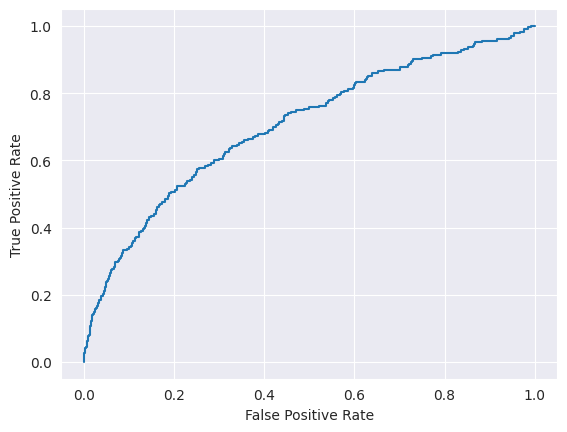

In [56]:
# ROC-AUC
# ROC - график, который иллюстрирует производительность классификационной модели при всех возможных порогах классификации
# AUC - (Area Under the ROC Curve) мера, которая позволяет суммировать производительность модели одним числом, измеряя площадь под кривой ROC
# Ось X - представляет собой FPR, т.е ложноположительную частоту
# Ось Y — TRP, т.е истинноположительную частоту - полнота (Recall)

# FPR = FP / (TN + FP)
# TRP = Recall = TP / (TP + FN)
# Precision = TP / (TP + FP)

# TP — истинно положительные
# TN — истинно отрицательные
# FP — ложно положительные
# FN — ложно отрицательные

# from sklearn.metrics import roc_auc_score

roc_auc = roc_auc_score(y_test, y_prediction_proba)
print('ROC-AUC: ', roc_auc)

# строим кривую
fpr, tpr, _ = metrics.roc_curve(y_test, y_prediction_proba)
# построение ROC кривой
plt.plot(fpr, tpr)
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

In [ ]:
# F1-мера
# гармоническое среднее между точностью (Precision) и полнотой (Recall), используемое для оценки качества классификации

# F1 = 2 * ((Precision * Recall) / (Precision + Recall))

# Интерпретация:
# 0-0.5: низкое качество модели.
# 0.5-0.7: приемлемый результат.
# >0.8: высокая точность и полнота

# from sklearn.metrics import f1_score

In [60]:
# Для бинарной классификации
f1 = f1_score(y_test, y_prediction) # 0.025862068965517238
print('F1-мера: ', f1)

F1-мера:  0.017777777777777778


In [61]:
# Для многоклассовой классификации
f1 = f1_score(y_test, y_prediction, average='macro') # усреднение F1 по всем классам
print('Macro-F1-мера: ', f1) # 0.5039670490789826
f1 = f1_score(y_test, y_prediction, average='micro') # глобальный расчёт через суммарные TP/FP/FN
print('Micro-F1-мера: ', f1) # 0.9647920236797008
f1 = f1_score(y_test, y_prediction, average='weighted') # Дисбаланс классов
print('Weighted-F1-мера: ', f1) # 0.9481078804260139

Macro-F1-мера:  0.5001280865421037
Micro-F1-мера:  0.9655709612089111
Weighted-F1-мера:  0.9489641037175702


In [62]:
# from sklearn.metrics import precision_recall_curve, PrecisionRecallDisplay

In [63]:
# Вычисление Precision и Recall
precision, recall, thresholds = precision_recall_curve(y_test, y_prediction_proba)

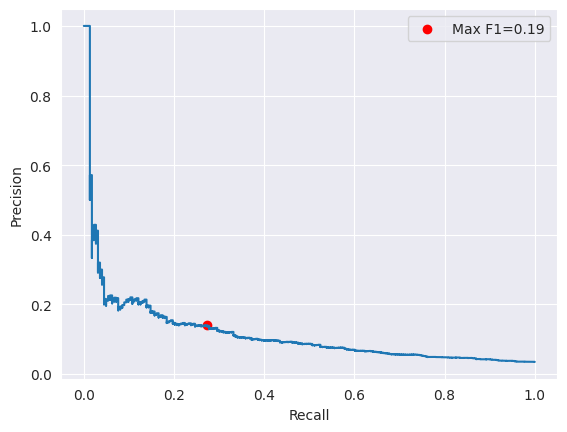

In [67]:
# Построение кривой
disp = PrecisionRecallDisplay(precision=precision, recall=recall)
disp.plot();

# Добавление изолиний F1
f1_scores = 2 * (precision * recall) / (precision + recall + 1e-10)
best_idx = np.argmax(f1_scores)
plt.scatter(recall[best_idx], precision[best_idx], c='red', label=f'Max F1={f1_scores[best_idx]:.2f}')
plt.legend()
plt.show()

точность (Precision):  [0.03474061 0.03474603 0.03475144 ... 1.         1.         1.        ]
полнота (Recall):  [1.         1.         1.         ... 0.00896861 0.0044843  0.        ]


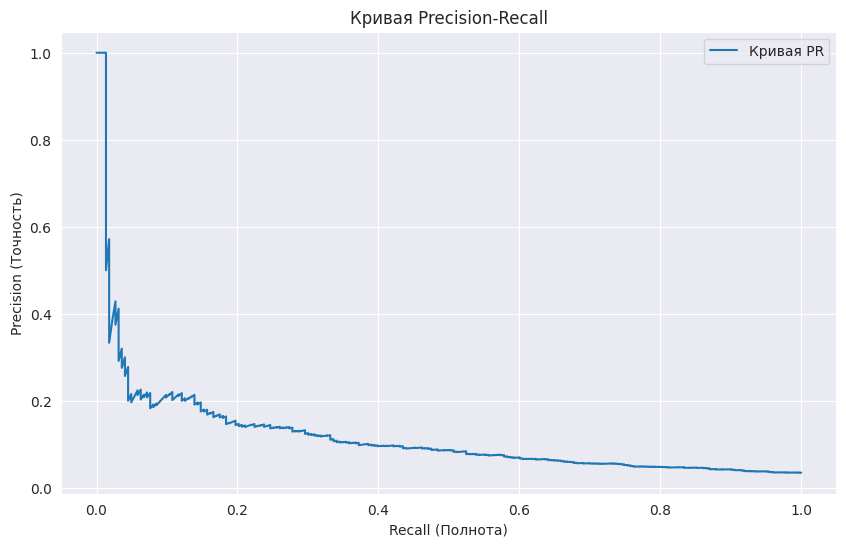

In [68]:
print('точность (Precision): ', precision)
print('полнота (Recall): ', recall)

# Базовый график Precision-Recall
plt.figure(figsize=(10, 6))
plt.plot(recall, precision, label='Кривая PR')
plt.xlabel('Recall (Полнота)')
plt.ylabel('Precision (Точность)')
plt.title('Кривая Precision-Recall')
plt.legend()
plt.grid(True)
plt.show()